# Tiny NeRF

In [1]:
import os, sys
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import Optional

In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

## Load data and visualize

In [2]:
data = np.load('tiny_nerf_data.npz')
images = data['images'] # (N_views, H, W, 3)
poses = data['poses'] # (N_views, 4, 4)
focal = data['focal'] # () in pixels
print(images.shape, poses.shape, focal)

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


Device is cpu


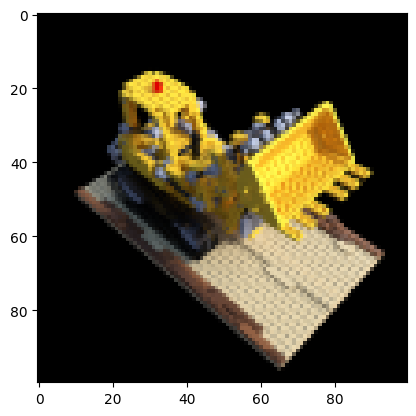

In [3]:
height, width = images.shape[1:3]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
      device = torch.device('mps')

device = torch.device('cpu')

images = torch.from_numpy(images).to(device, dtype=torch.float32)
poses = torch.from_numpy(poses).to(device, dtype=torch.float32)
focal = torch.tensor(focal).to(device, dtype=torch.float32)

test_img, test_pose = images[101], poses[101]
images = images[:100]
poses = poses[:100]

print(f'Device is {device}')
plt.imshow(test_img.cpu().numpy())
plt.show()

## Helper Functions

In [4]:
def meshgrid_xy(
    tensor1: torch.Tensor, tensor2: torch.Tensor
) -> (torch.Tensor, torch.Tensor):
    i, j = torch.meshgrid(tensor1, tensor2)
    return i.transpose(-1, -2), j.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    dim = -1
    cumprod = torch.cumprod(tensor, dim)
    cumprod = torch.roll(cumprod, 1, dim)
    cumprod[..., 0] = 1.0

    return cumprod

## Positional Encoding

In [5]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True
) -> torch.Tensor:
    encoding = [tensor] if include_input else []

    for i in range(num_encoding_functions):
        for fn in [torch.sin, torch.cos]:
            encoding.append(fn(2.0**i * tensor))

    return torch.cat(encoding, dim=-1)

In [6]:
# testing posenc
x = torch.linspace(-1., 1., 10)
print(x)
positional_encoding(x).shape

tensor([-1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,  0.3333,  0.5556,
         0.7778,  1.0000])


torch.Size([130])

## Create model

In [29]:
class NeRF(torch.nn.Module):
    def __init__(self, D=8, W=256):
        super(NeRF, self).__init__()
        self.layer_1 = torch.nn.Linear(3 + 3 * 2 * D, W)

        self.layer_2 = torch.nn.Linear(W, W)
        self.layer_3 = torch.nn.Linear(W, W)

        self.layer_4 = torch.nn.Linear(W, 4)
        self.relu = torch.nn.functional.relu

    def forward(self, pts):
        x = self.layer_1(pts)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.layer_3(x)
        x = self.relu(x)
        x = self.layer_4(x)
        return x

In [8]:
def get_rays(height: int, width: int, focal_length: float, cam_2_world: torch.Tensor):
  i, j = meshgrid_xy(
      torch.arange(width).to(cam_2_world),
      torch.arange(height).to(cam_2_world)
  )
  directions = torch.stack([(i - width * .5) / focal_length,
                            -(j - height * .5) / focal_length,
                            -torch.ones_like(i)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * cam_2_world[:3, :3], dim=-1)
  ray_origins = cam_2_world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

In [13]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near: float,
    far: float,
    num_samples: int,
    rand: Optional[bool] = True,
) -> (torch.Tensor, torch.Tensor):
    depth_values = torch.linspace(near, far, num_samples).to(ray_origins)
    if rand is True:
        noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
        depth_values = (
            depth_values
            + torch.rand(noise_shape).to(ray_origins) * (far - near) / num_samples
        )
    query_points = (
        ray_origins[..., None, :]
        + ray_directions[..., None, :] * depth_values[..., :, None]
    )
    return query_points, depth_values

## Dataloader

In [10]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
    return [inputs[i : i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

## Volumetric Rendering

In [11]:
def render_volume_density(
    radiance_field: torch.Tensor, ray_origins: torch.Tensor, depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
    sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
    rgb = torch.sigmoid(radiance_field[..., :3])
    one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
    dists = torch.cat(
        (
            depth_values[..., 1:] - depth_values[..., :-1],
            one_e_10.expand(depth_values[..., :1].shape),
        ),
        dim=-1,
    )
    alpha = 1.0 - torch.exp(-sigma_a * dists)
    weights = alpha * cumprod_exclusive(1.0 - alpha + 1e-10)

    rgb_map = (weights[..., None] * rgb).sum(dim=-2)
    depth_map = (weights * depth_values).sum(dim=-1)
    acc_map = weights.sum(-1)

    return rgb_map, depth_map, acc_map

## Visualize Rays

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def plot_rays(cam2world, title):
    rays_o, rays_d = get_rays(height, width, focal, cam2world)
    query_points, depth_values = compute_query_points_from_rays(
        rays_o, rays_d, 2.0, 6.0, 5
    )
    rays_o = rays_o.reshape((-1, 3))
    rays_o = rays_o.detach().cpu().numpy()

    fig = go.Figure()
    fig.add_trace(
        go.Scatter3d(
            x=rays_o[:, 0],
            y=rays_o[:, 1],
            z=rays_o[:, 2],
            mode="markers",
            name="camera",
        )
    )

    # show query points
    query_points = query_points.reshape((-1, 3))
    query_points = query_points.detach().cpu().numpy()
    fig.add_trace(
        go.Scatter3d(
            x=query_points[:, 0],
            y=query_points[:, 1],
            z=query_points[:, 2],
            mode="markers",
            name="query_points",
            marker=dict(size=1, opacity=0.5),
        )
    )

    fig.update_layout(title=title)
    fig.show()


plot_rays(test_pose, "rays in world space")

## Train

In [30]:
def run_one_iter_of_tinynerf(
    height,
    width,
    focal_length,
    cam2world,
    near_thresh,
    far_thresh,
    depth_samples_per_ray,
    encoding_func,
    get_minibatches_function,
):
    ray_origins, ray_directions = get_rays(height, width, focal_length, cam2world)

    # Sample query points along each ray
    query_points, depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
    )

    # flatten the query points.
    flattened_query_points = query_points.reshape((-1, 3))

    encoded_points = encoding_func(flattened_query_points)

    batches = get_minibatches(encoded_points, chunksize=chunksize)
    predictions = []
    for batch in batches:
        predictions.append(model(batch))
    radiance_field_flattened = torch.cat(predictions, dim=0)

    # make the shape of the radiance field back to the shape of the query points. (4 is for sigma_a + rgb)
    unflattened_shape = list(query_points.shape[:-1]) + [4]
    radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

    # Do volumetric rendering to compute the final RGB values.
    rgb_predicted, _, _ = render_volume_density(
        radiance_field, ray_origins, depth_values
    )

    return rgb_predicted

In [33]:
def create_and_train_model(use_tensorboard: bool = False):
    if use_tensorboard:
        from torch.utils.tensorboard import SummaryWriter

        writer = SummaryWriter(log_dir="logs")

    global model
    model = NeRF(D=num_encoding_functions)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    seed = 30
    torch.manual_seed(seed)
    np.random.seed(seed)

    psnrs = []
    iternums = []

    pbar = tqdm(range(num_iters))
    for i in pbar:
        # Randomly pick an image as the target
        target_img_idx = np.random.randint(images.shape[0])
        target_img = images[target_img_idx].to(device)
        target_tform_cam2world = poses[target_img_idx].to(device)

        rgb_predicted = run_one_iter_of_tinynerf(
            height,
            width,
            focal,
            target_tform_cam2world,
            near_thresh,
            far_thresh,
            depth_samples_per_ray,
            pos_enc,
            get_minibatches,
        )

        loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if use_tensorboard:
            writer.add_scalar("Loss/train", loss.item(), i)
            writer.add_scalar("PSNR/train", -10.0 * torch.log10(loss), i)

        if i % display_every == 0:
            pbar.set_description(f"Loss: {loss.item()}")
            psnr = -10.0 * torch.log10(loss)

            psnrs.append(psnr.item())
            iternums.append(i)

            if use_tensorboard:
                writer.add_image("Target", target_img.permute(2, 0, 1), i)
                writer.add_image("Predicted", rgb_predicted.permute(2, 0, 1), i)
            else:
                plt.figure(figsize=(10, 4))
                plt.subplot(121)
                plt.imshow(rgb_predicted.detach().cpu().numpy())
                plt.title(f"Iteration {i}")
                plt.subplot(122)
                plt.plot(iternums, psnrs)
                plt.title("PSNR")
                plt.show()

    print("Done!")
    return model

Loss: 0.1301550418138504:   0%|          | 0/1000 [00:00<?, ?it/s]

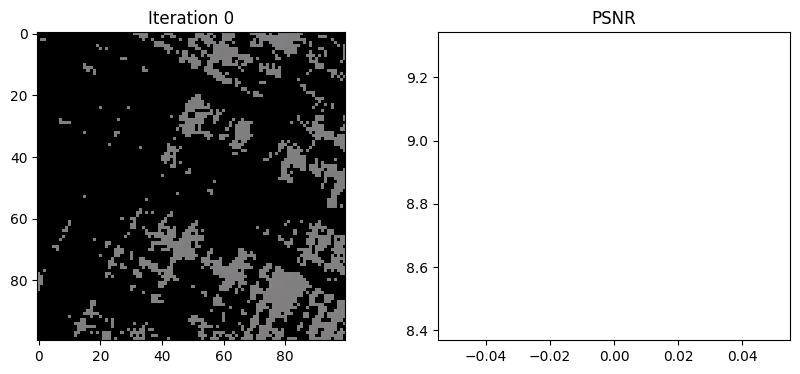

Loss: 0.015828922390937805:  10%|█         | 100/1000 [00:59<08:38,  1.73it/s]

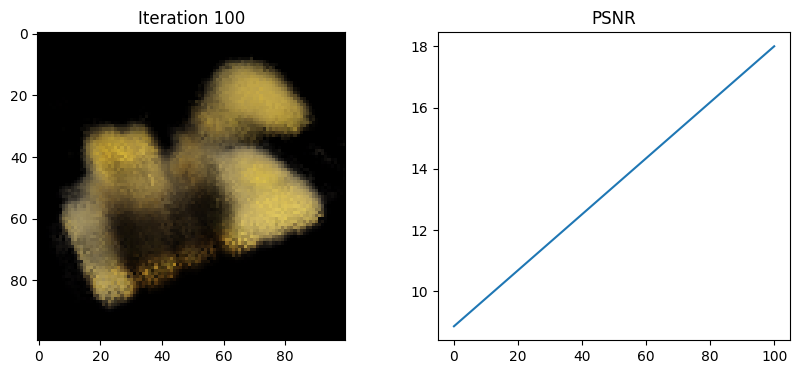

Loss: 0.00734506594017148:  20%|██        | 200/1000 [01:58<07:42,  1.73it/s] 

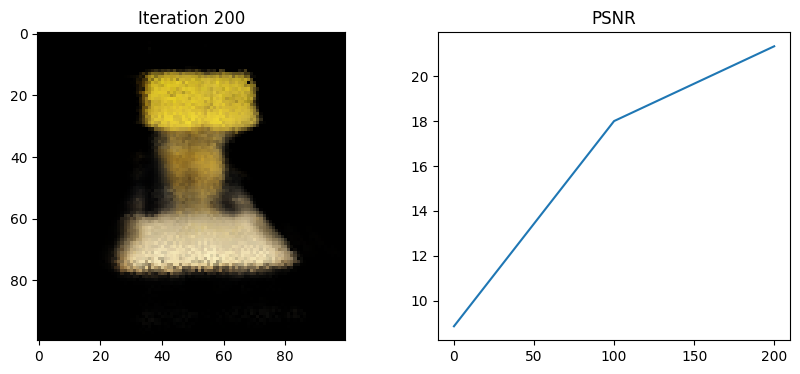

Loss: 0.00670010456815362:  30%|███       | 300/1000 [02:58<06:45,  1.73it/s]

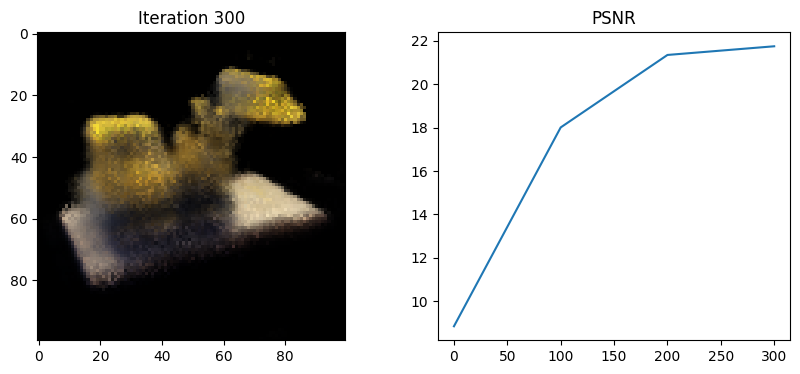

Loss: 0.006813716609030962:  40%|████      | 400/1000 [03:55<05:43,  1.75it/s]

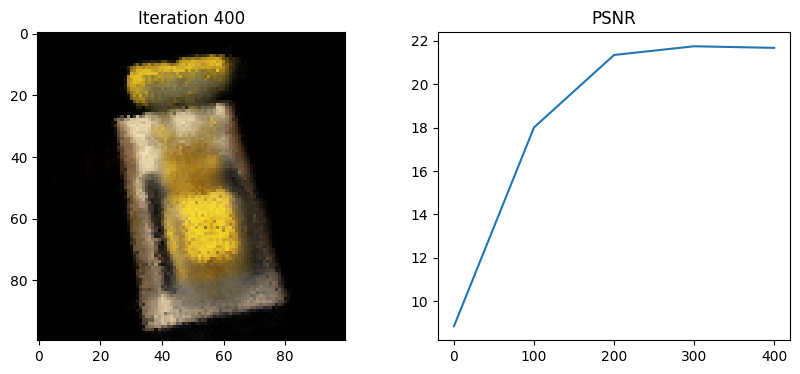

Loss: 0.007942693307995796:  50%|█████     | 500/1000 [04:51<04:46,  1.74it/s]

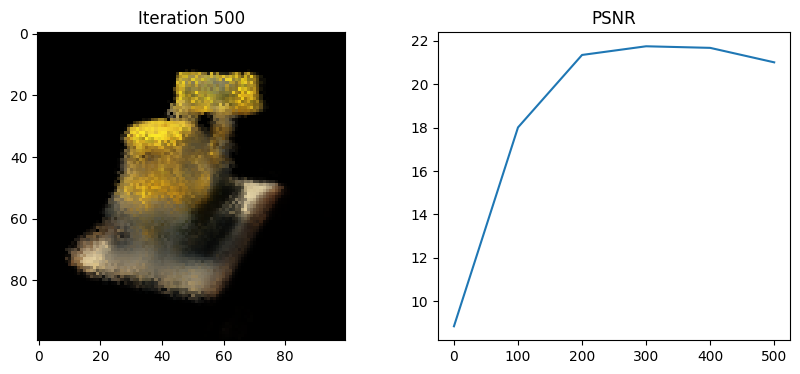

Loss: 0.009310589171946049:  60%|██████    | 600/1000 [05:48<03:49,  1.74it/s]

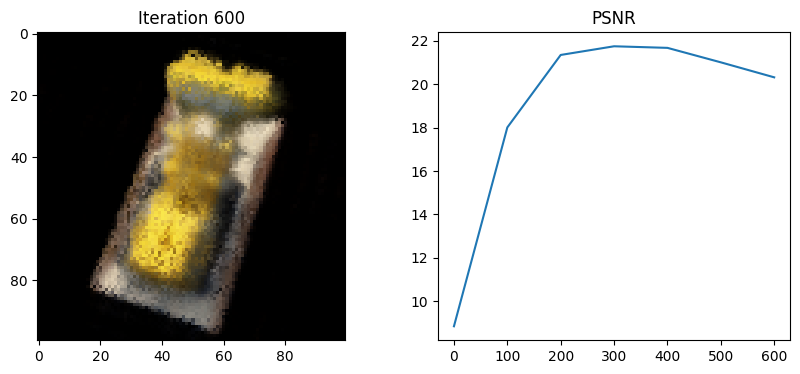

Loss: 0.0045272293500602245:  70%|███████   | 700/1000 [06:46<02:51,  1.74it/s]

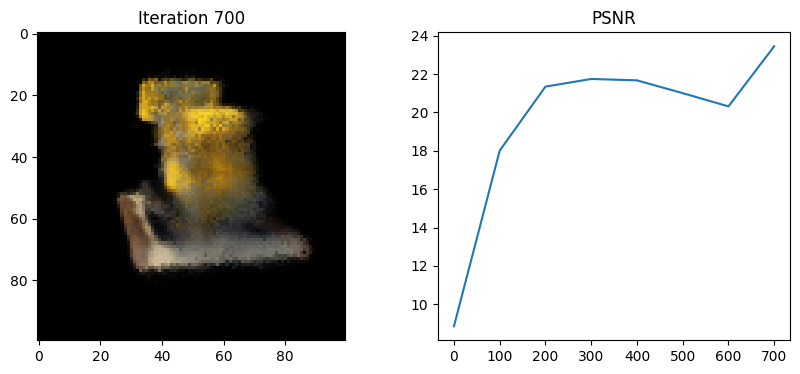

Loss: 0.008630980737507343:  80%|████████  | 800/1000 [07:44<01:54,  1.74it/s] 

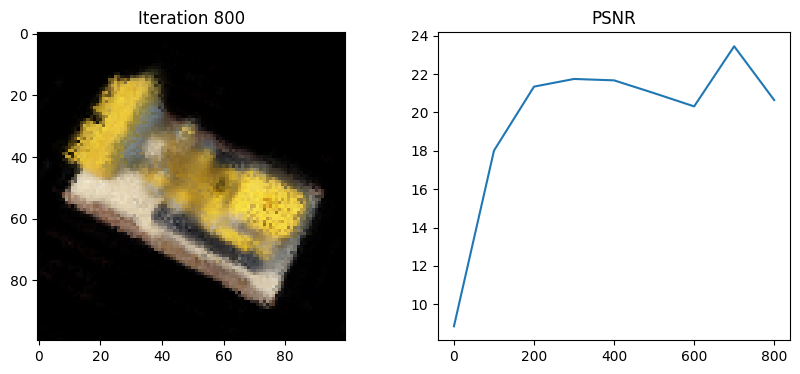

Loss: 0.008683588355779648:  90%|█████████ | 900/1000 [08:43<00:58,  1.71it/s]

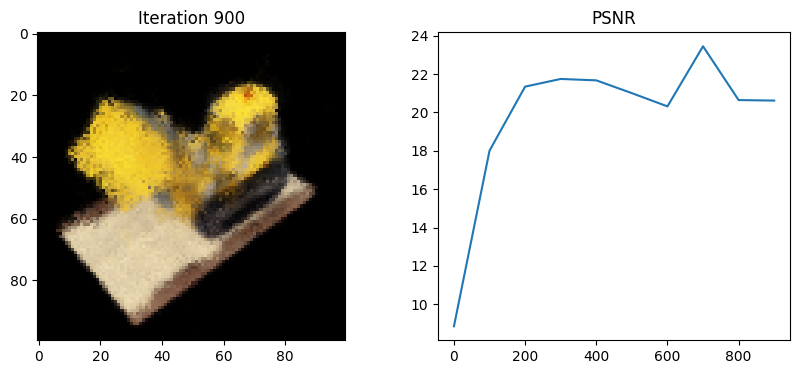

Loss: 0.008683588355779648: 100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]

Done!


In [32]:
near_thresh = 2.0
far_thresh = 6.0

num_encoding_functions = 6

pos_enc = lambda x: positional_encoding(
    x, num_encoding_functions=num_encoding_functions
)

depth_samples_per_ray = 32

chunksize = 16384

lr = 5e-3
num_iters = 1000

display_every = 100

model = create_and_train_model(use_tensorboard=False)

## Test the model

In [36]:
def evaluate_model(
    model,
    test_images,
    test_poses,
    test_focal: Optional = focal,
    use_tensorboard: bool = False,
):
    if use_tensorboard:
        from torch.utils.tensorboard import SummaryWriter

        writer = SummaryWriter(log_dir="logs")

    test_images = test_images.to(device)
    test_poses = test_poses.to(device)
    test_focal = test_focal.to(device)

    pbar = tqdm(range(test_images.shape[0]))
    for i in pbar:
        test_image = test_images[i]
        test_pose = test_poses[i]
        with torch.no_grad():
            rgb_predicted = run_one_iter_of_tinynerf(
                height,
                width,
                test_focal,
                test_pose,
                near_thresh,
                far_thresh,
                depth_samples_per_ray,
                pos_enc,
                get_minibatches,
            )
            loss = torch.nn.functional.mse_loss(rgb_predicted, test_image)

        pbar.set_description(f"Loss: {loss.item()}")
        if use_tensorboard:
            writer.add_image("Test_Target", test_image.permute(2, 0, 1), i)
            writer.add_image("Test_Prediction", rgb_predicted.permute(2, 0, 1), i)
            writer.add_scalar("Loss/test", loss.item(), i)

        else:
            plt.figure(figsize=(10, 4))
            plt.subplot(121)
            plt.imshow(rgb_predicted.detach().cpu().numpy())
            plt.title(f"Test Image")
            plt.subplot(122)
            plt.imshow(test_image.detach().cpu().numpy())
            plt.title(f"Ground Truth")
            plt.show()

Loss: 0.007001375313848257:   0%|          | 0/5 [00:00<?, ?it/s]

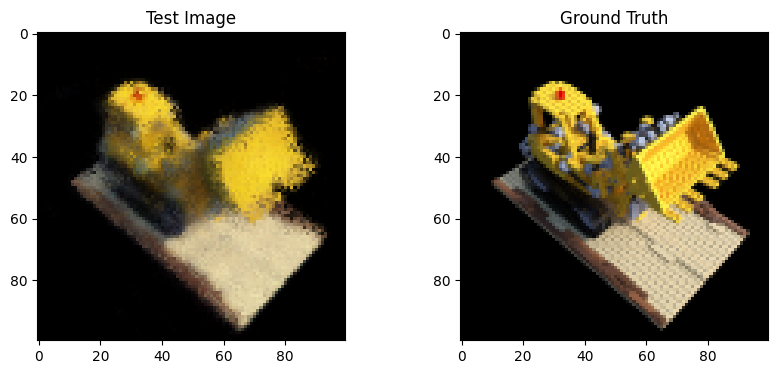

Loss: 0.006262804847210646:  20%|██        | 1/5 [00:00<00:01,  3.12it/s]

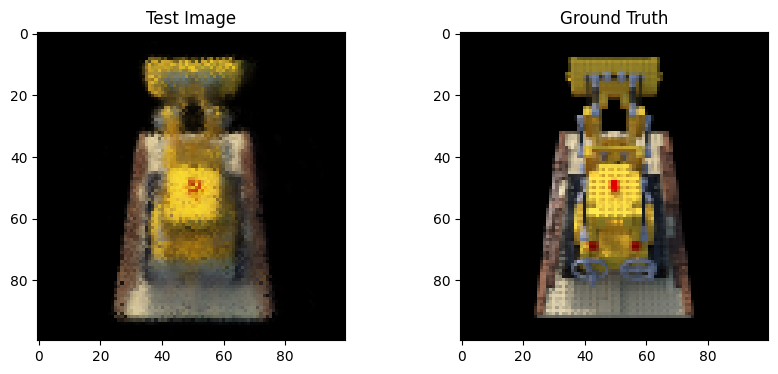

Loss: 0.005715486593544483:  40%|████      | 2/5 [00:00<00:00,  3.05it/s]

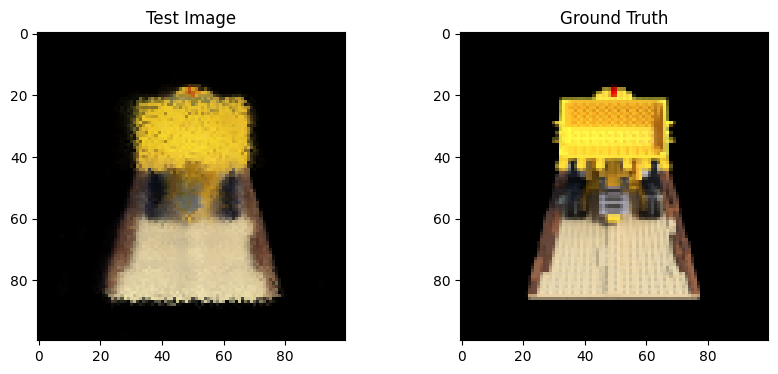

Loss: 0.003759657498449087:  60%|██████    | 3/5 [00:01<00:00,  3.13it/s]

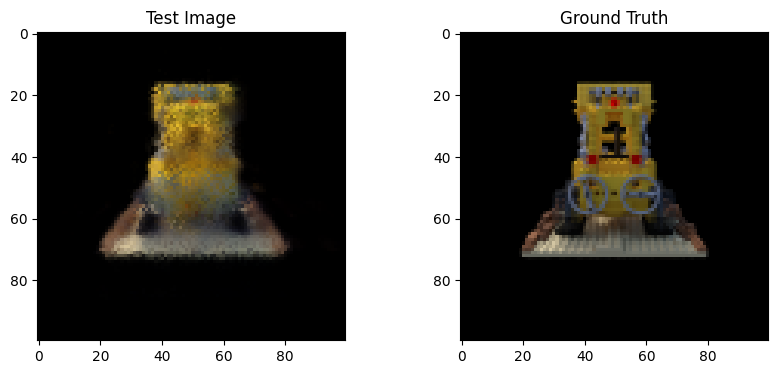

Loss: 0.005783395376056433:  80%|████████  | 4/5 [00:01<00:00,  3.12it/s]

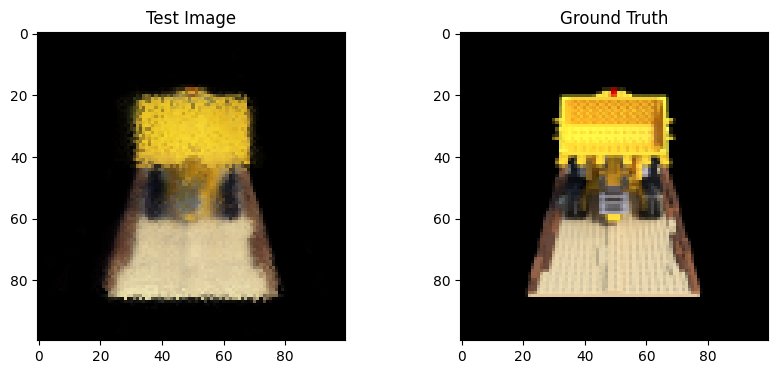

Loss: 0.005783395376056433: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


In [37]:
test_images = torch.from_numpy(data["images"][101:])
test_poses = torch.from_numpy(data["poses"][101:])
evaluate_model(model, test_images, test_poses, use_tensorboard=False)